In [1]:
import os
import pandas as pd
import json
import pickle
from collections import defaultdict
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

import torch

import os, sys
parentPath = os.path.abspath("..")
if parentPath not in sys.path:
    sys.path.insert(0, parentPath)
    
from src.data import load_source, slice_d
from src.config import Config, get_option_fallback
from knowledge_tracing.trainer import Trainer

/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/pandas/compat/__init__.py:84: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/root/.pyenv/versions/3.7.4/lib/python3.7/site-packages/pandas/compat/__init__.py:84: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
projectdir = Path('/code')
assert projectdir.exists()

In [3]:
experiment_name = '20_0218_edm2020_assistments09'
expsoutdir = projectdir / 'output' / experiment_name
cp_rp_paths = []
for expdir in sorted(expsoutdir.iterdir()):
    # Checkpoints
    cpdir = expdir / 'checkpoints'
    lastcpdir = sorted(cpdir.iterdir())[-1]
    bestcp_path = sorted(lastcpdir.iterdir())[-1]
    print(bestcp_path)
    # Report
    rpdir = expdir / 'report'
    lastrpdir = sorted(rpdir.iterdir())[-1]
    rp_path = next(lastrpdir.glob('*.json'))
    print(rp_path)
    cp_rp_paths.append((bestcp_path, rp_path))
    
# Asteria
configdics = []
for checkpoint_path, report_path in cp_rp_paths:
    with open(report_path, 'r') as f:
        report = json.load(f)
        config_dic = report['config']
        config_dic['load_model'] = str(checkpoint_path)
        configdics.append(config_dic)
        
def get_simu_res(config_dic):
    config = Config(config_dic, projectdir)
    config.batch_size = 1
    trainer = Trainer(config)
    
    trainer.evaluate_model()


    seq_size = config.sequence_size
    simu = [[0]*i + [1]*(seq_size - i) for i in range(seq_size+1)]

    simu_res = dict()
    for v in range(config.n_skills):
        xs = []
        preds = []
        for s in simu:
            res = trainer.model.loss_batch(
                torch.Tensor([(v,a) for a in s]).unsqueeze(0),
                torch.Tensor([(v,a) for a in s]).unsqueeze(0),
                torch.BoolTensor([True]*seq_size).unsqueeze(0),)
            preds.append(res['pred_prob'][-1].item())
            xs.append(sum(s))
        simu_res[v] = (xs, preds)
    return simu_res


simures_list = []
for config_dic in configdics:
    simu_res = get_simu_res(config_dic)
    simures_list.append(simu_res)
    

base_res = None
descres_list = []
for simu_res in simures_list:
    if base_res is None:
        base_res = {k:v for k, v in sorted(simu_res.items(), key=lambda it: it[1][1][0] - it[1][1][-1])}
    else:
        desc_res = {k:simu_res[k] for k in base_res.keys()}
        descres_list.append(desc_res)

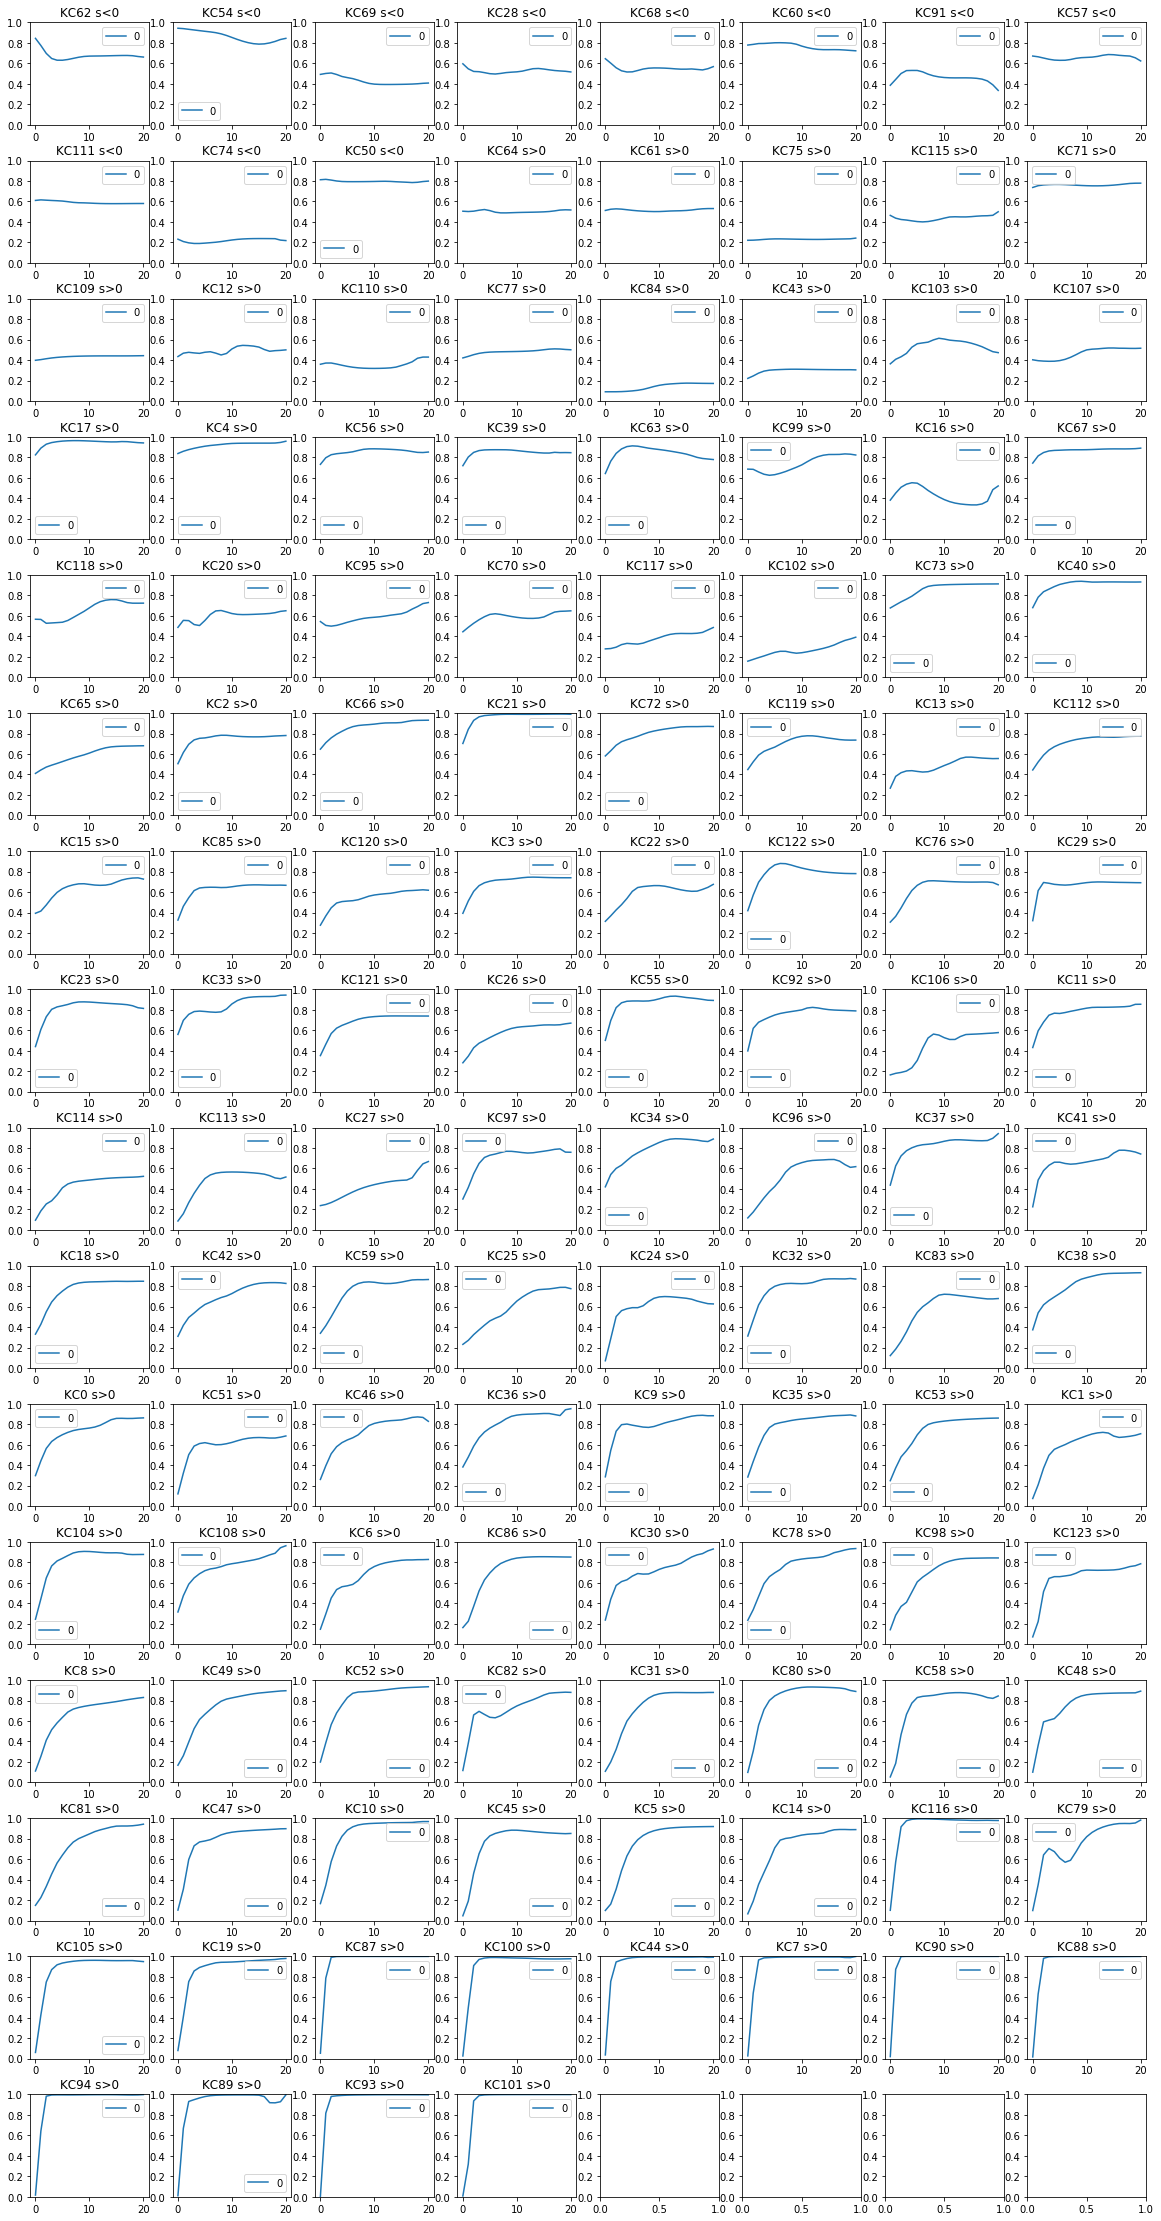

In [4]:
        
h, w = (124+7)//8, 8
figscale = 2.5
hspace = 0.35
fig, axs = plt.subplots(h, w, figsize=(w*figscale, h*figscale))
plt.subplots_adjust(hspace=hspace)
for i, (v, (xidx, sanity)) in enumerate(list(base_res.items())[:h*w]):
    ax = axs[i//(w), i%(w)]
    ax.set_ylim([0, 1])
    ax.set_title('KC{} s{}0'.format(v, '>' if sanity[-1]<sanity[0] else '<'))
    sns.lineplot(xidx, sanity, ax=ax, label='0', palette="ch:2.5,.25")
    for i, desc_res in enumerate(descres_list):
        sns.lineplot(xidx, desc_res[v][1], ax=ax, label=str(i+1), palette="ch:2.5,.25")
ax.legend()
plt.show()